# 🏥 Healthcare Admissions & Cost Analysis
### An end-to-end data analytics case study using Python
      
This project analyzes a synthetic healthcare admissions dataset to understand patient demand, cost drivers, and operational patterns across hospitals.

### 🎯 Goals
Translate raw healthcare data into insights for improving:
- Staffing & scheduling
- Cost management
- Insurance reimbursement analysis
- Patient demographics understanding
- Length-of-stay efficiency
- Case-mix differences across hospitals

### 📌 Business Questions Answered
- **Q1.** What are the busiest days of the week for admissions?
- **Q2.** Which medical conditions drive the highest total cost and the highest cost per patient?
- **Q3.** How do costs vary by insurance provider and medical condition?
- **Q4.** What are typical lengths of stay by medical condition and admission type?
- **Q5.** What is the demographic profile of patients for each major medical condition?
- **Q6.** Are some hospitals consistently seeing certain types of patients (older/sicker)?

We'll use Python (pandas, matplotlib, seaborn) to clean, analyze, and visualize the data to find out.

## 📂 Step 1 — Load & Prepare the Dataset

We begin by importing the CSV version of the healthcare dataset, inspecting its structure,
and preparing the engineered columns needed for analysis:

The key transformations include:
- Converting all date fields into proper datetime format
- Extracting the **weekday** from each admission date
- Calculating **Length of Stay (LOS)** using admission and discharge dates
- Creating **age bands** for demographic profiling


In [10]:
import pandas as pd
import numpy as np

df = pd.read_csv("healthcare_dataset_py.csv")
df["Name"] = df["Name"].str.title()
df["Billing Amount"] = df["Billing Amount"].round(2)

df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])

df['Weekday'] = df['Date of Admission'].dt.day_name()

df['LOS'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

bins = [0,17,35,50,65,120]
labels = ["0-17","18-35","36-50","51-65","65+"]
df['Age Band'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Weekday,LOS,Age Band
0,Bobby Jackson,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.28,328,Urgent,2024-02-02,Paracetamol,Normal,Wednesday,2,18-35
1,Leslie Terry,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.33,265,Emergency,2019-08-26,Ibuprofen,Inconclusive,Tuesday,6,51-65
2,Danny Smith,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.10,205,Emergency,2022-10-07,Aspirin,Normal,Thursday,15,65+
3,Andrew Watts,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.78,450,Elective,2020-12-18,Ibuprofen,Abnormal,Wednesday,30,18-35
4,Adrienne Bell,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.32,458,Urgent,2022-10-09,Penicillin,Abnormal,Monday,20,36-50


# 📅 Q1. What Are the Busiest Days of the Week?

### 🔍 Business Purpose?
Hospitals use patient volume to help schedule staff appropriately.  
Understanding weekday patterns helps to optimize:

- Nursing coverage  
- Physician rounds  
- Operating room scheduling  
- ER staffing  

### 🧠 The Plan?
1. Count admissions by weekday  
2. Compare emergency vs routine vs urgent  
3. Visualize the patterns  

In [24]:
weekday_counts = df['Weekday'].value_counts().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
weekday_counts

Weekday
Monday       7866
Tuesday      7982
Wednesday    7950
Thursday     7989
Friday       7892
Saturday     7901
Sunday       7920
Name: count, dtype: int64

In [12]:
weekday_type = df.groupby(['Weekday','Admission Type']).size().unstack(fill_value=0)
weekday_type = weekday_type.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
weekday_type

Admission Type,Elective,Emergency,Urgent
Weekday,,,
Monday,2659,2597,2610
Tuesday,2736,2645,2601
Wednesday,2650,2597,2703
Thursday,2715,2609,2665
Friday,2618,2628,2646
Saturday,2612,2591,2698
Sunday,2665,2602,2653


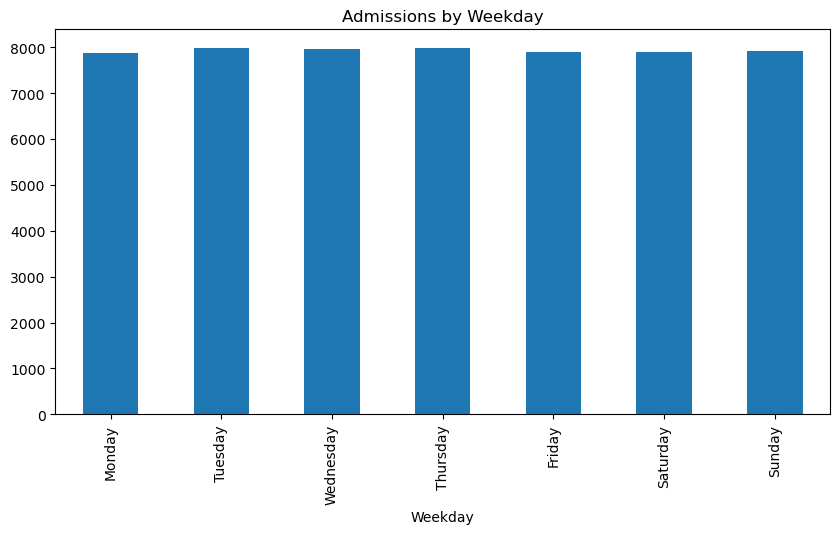

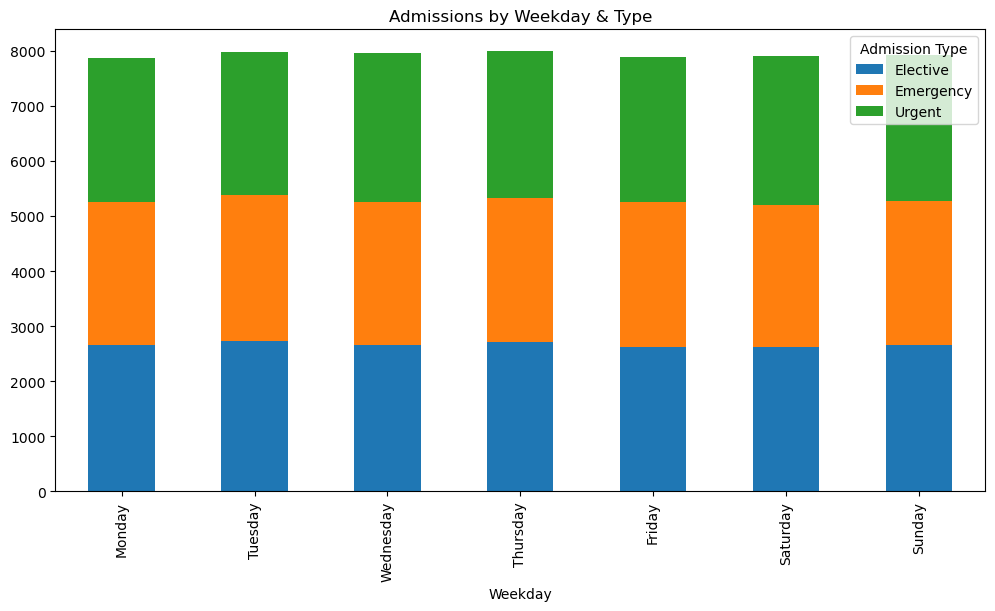

In [13]:
import matplotlib.pyplot as plt

weekday_counts.plot(kind='bar', figsize=(10,5), title="Admissions by Weekday")
plt.show()

weekday_type.plot(kind='bar', stacked=True, figsize=(12,6),
                 title="Admissions by Weekday & Type")
plt.show()

# 💰 Q2 — Which Medical Conditions Drive the Highest Cost?

### 🔍 Business Purpose?
Identifying high-cost conditions helps with:
- Budget planning  
- Care pathway improvement  
- Resource allocation  

### 🧠 The Plan?
Group by **Medical Condition** and calculate:
- Total billing  
- Number of patients  
- Average cost per patient  
- Average cost per admission  

In [14]:
condition_summary = (
    df.groupby("Medical Condition")
      .agg(
          total_billing=("Billing Amount", "sum"),
          encounters=("Billing Amount", "count"),
          unique_patients=("Name", "nunique"),
          avg_bill_per_admission=("Billing Amount", "mean")
      )
      .sort_values("total_billing", ascending=False))
condition_summary = condition_summary.round(0)

condition_summary.head(10)

,total_billing,encounters,unique_patients,avg_bill_per_admission
Medical Condition,,,,
Diabetes,238539725.0,9304,7950,25638.0
Obesity,238214920.0,9231,7844,25806.0
Arthritis,237329120.0,9308,8019,25497.0
Hypertension,235720650.0,9245,7870,25497.0
Asthma,235459765.0,9185,7837,25635.0
Cancer,232167861.0,9227,7853,25162.0


# 🧾 Q3 — How Do Costs Vary by Insurance Provider × Condition?

### 🔍 Business Purpose
Payer-mix analysis helps hospitals:
- Understand reimbursement patterns  
- Prepare for insurance contract negotiations  
- Detect under or over-payment trends  

### 🧠 Analytical Plan
1. Group by Insurance + Condition  
2. Calculate average + total billing  
3. Pivot into a heatmap-ready table 

In [15]:
insurance_condition = (
    df.groupby(["Insurance Provider","Medical Condition"])
      .agg(
          avg_bill=("Billing Amount","mean"),
          total_bill=("Billing Amount","sum"),
          count=("Billing Amount","count")
      )
)
insurance_condition = insurance_condition.round(0)
insurance_condition.head()

avg_bill  total_bill  count
Insurance Provider Medical Condition                             
Aetna              Arthritis           25479.0  46677444.0   1832
                   Asthma              25847.0  44973713.0   1740
                   Cancer              24923.0  45335683.0   1819
                   Diabetes            25565.0  47091077.0   1842
                   Hypertension        25896.0  48581299.0   1876

In [16]:
pivot_ins = insurance_condition['avg_bill'].unstack().fillna(0)
pivot_ins

Medical Condition,Arthritis,Asthma,Cancer,Diabetes,Hypertension,Obesity
Insurance Provider,,,,,,
Aetna,25479.0,25847.0,24923.0,25565.0,25896.0,25612.0
Blue Cross,25793.0,25142.0,25101.0,25820.0,25696.0,26101.0
Cigna,25318.0,25610.0,25582.0,25651.0,24860.0,26117.0
Medicare,25272.0,25766.0,25338.0,25671.0,25812.0,25839.0
UnitedHealthcare,25627.0,25820.0,24858.0,25478.0,25216.0,25340.0


### 🔥 Heatmap — Average Billing by Insurance Provider & Condition

Now that we have `pivot_ins` (rows = insurance providers, columns = medical conditions,
values = average bill), we can turn it into a heatmap.

- Darker cells = higher average bill
- Lighter cells = lower average bill

This gives us a quick way to see which payer–condition combos are most expensive.

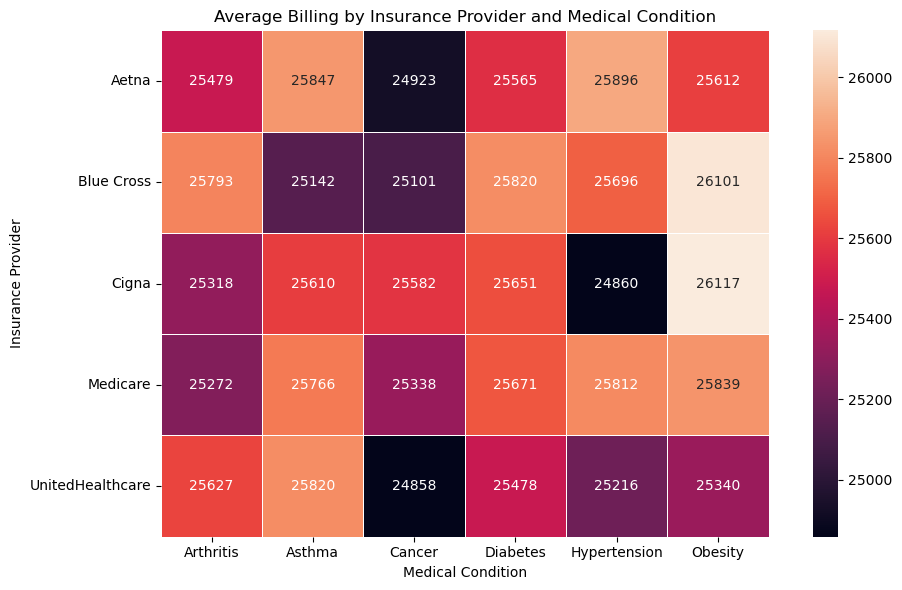

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_ins,
    annot=True,       
    fmt=".0f",         
    linewidths=0.5,    
    square=True        
)

plt.title("Average Billing by Insurance Provider and Medical Condition")
plt.xlabel("Medical Condition")
plt.ylabel("Insurance Provider")
plt.tight_layout()
plt.show()

# ⏱️ Q4 — Length of Stay (LOS) by Condition & Admission Type

### 🔍 Business Purpose?
LOS is a major operational driver that affects:
- Bed/room turnover  
- Staffing  
- Costs  
- Efficiency metrics  

### 🧠 The Plan?
1. Use LOS column  
2. Group by condition & admission type  
3. Plot distributions  

In [17]:
los_summary = df.groupby(["Medical Condition","Admission Type"])["LOS"].mean().reset_index()
los_summary.head()

,Medical Condition,Admission Type,LOS
0,Arthritis,Elective,15.631852
1,Arthritis,Emergency,15.510296
2,Arthritis,Urgent,15.411293
3,Asthma,Elective,15.743391
4,Asthma,Emergency,15.577615


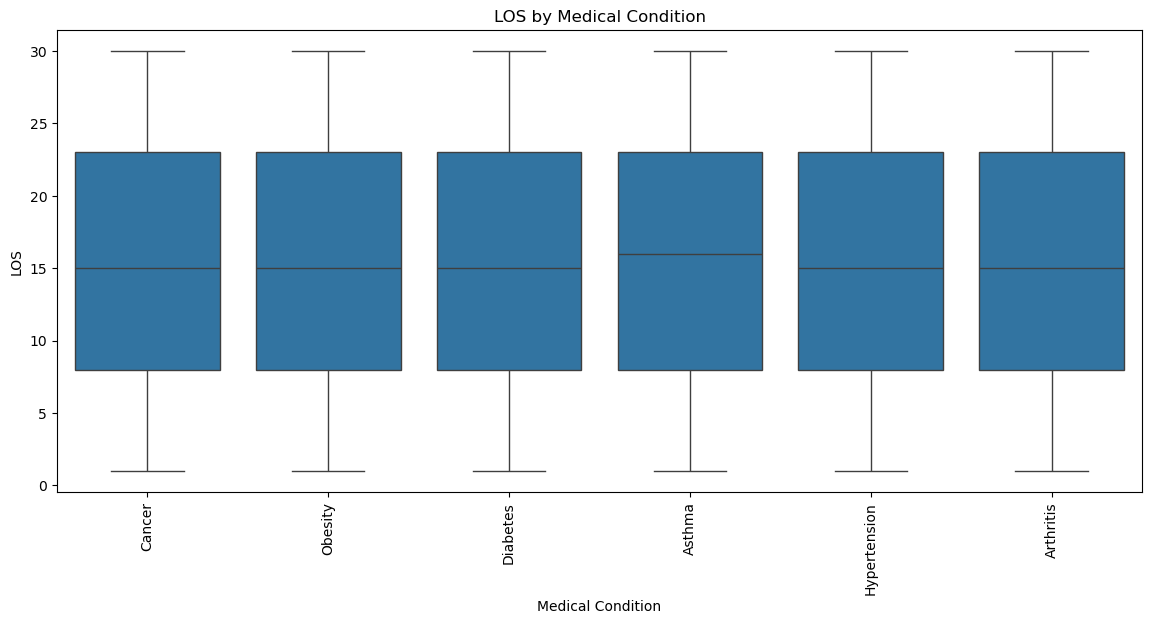

In [18]:
import seaborn as sns

plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="Medical Condition", y="LOS")
plt.xticks(rotation=90)
plt.title("LOS by Medical Condition")
plt.show()

# 👨‍⚕️ Q5 — Patient Demographics by Condition

### 🔍 Business Purpose?
Demographics uncover:
- Age-specific conditions  
- Gender-based patterns  
- Preventative program opportunities  

### 🧠 The Plan?
- Use **Age Band** and Gender  
- Crosstab against condition  

In [19]:
demo_crosstab = pd.crosstab(df['Medical Condition'], df['Age Band'])
demo_crosstab.head()

Age Band,0-17,18-35,36-50,51-65,65+
Medical Condition,,,,,
Arthritis,11,2279,2072,2062,2884
Asthma,17,2280,2018,1976,2894
Cancer,14,2280,2028,2067,2838
Diabetes,12,2243,2108,2103,2838
Hypertension,8,2262,2026,2070,2879


In [20]:
demo_gender = pd.crosstab(df['Medical Condition'], df['Gender'])
demo_gender.head()

Gender,Female,Male
Medical Condition,,
Arthritis,4686,4622
Asthma,4553,4632
Cancer,4602,4625
Diabetes,4651,4653
Hypertension,4612,4633


# 🏥 Q6 — Do Hospitals See Older or Sicker Patients?

### 🔍 Business Purpose?
Case-mix analysis tells us:
- Which hospitals are more geriatric-heavy  
- Which hospitals treat more complex conditions  
- Resource allocation needs  

### 🧠 The Plan?
1. Compare mean age per hospital  
2. Compare condition distributions

In [21]:
age_hosp = df.groupby("Hospital")["Age"].mean().sort_values(ascending=False)
age_hosp

Hospital
and Martin, Davidson Cox       87.0
Cooper Brown Parks, and        87.0
Holmes and Howard Castro,      87.0
and Perez, Bennett Townsend    87.0
Gray-Solomon                   87.0
                               ... 
Davis-Lawrence                 15.5
Pollard Wallace, Sims and      15.5
Small-Shaw                     15.5
and Huerta, Cox Price          15.5
Thomas-Pierce                  15.5
Name: Age, Length: 39876, dtype: float64

In [22]:
cond_hosp = pd.crosstab(df['Hospital'], df['Medical Condition'])
cond_hosp.head()

Medical Condition,Arthritis,Asthma,Cancer,Diabetes,Hypertension,Obesity
Hospital,,,,,,
Abbott Inc,1,0,0,0,0,0
Abbott Ltd,1,0,0,0,0,0
"Abbott Moore and Williams,",0,0,0,0,0,1
"Abbott and Thompson, Sullivan",0,0,0,0,1,0
"Abbott, Peters and Hoffman",0,0,0,2,0,0


# 📊 Key Findings & Business Recommendations

Below is a consolidated summary of insights from **Q1–Q6**, written in crisp, stakeholder-friendly language using numbers from our analysis.

---

## ✅ Q1 — Busiest Days of the Week

### **Findings**
- Admissions are very consistent across all 7 days (**~7,860–8,000 admissions/day**).
- The difference between the slowest day (Monday) and the busiest (Tuesday/Thursday) is only **1–2%**.
- Emergency, elective, and urgent volumes each average about **~2,600–2,700/day**.

### **Implications**
- There is **no meaningful “slow day”** for any major staffing reductions.
- Supports **uniform daily staffing**.

### **Recommendations**
- Maintain **consistent staffing levels** across all days.
- If needed: add slight coverage on **Tuesdays & Thursdays** (+1–2 clinicians).

---

## 💰 Q2 — Which Medical Conditions Drive the Highest Cost?

### **Findings**
- **Top total-billing conditions:**
  - **Diabetes:** ~$238M  
  - **Obesity:** ~$238M  
  - **Arthritis:** ~$237M  
- Each condition has **~9,000 encounters**.
- Each condition has **~7,800–8,000 unique patients**.
- The average bill per admission is nearly identical across conditions (**$25k–$26k** with only a **1–3% difference**).

### **Implications**
- These conditions are both **high-volume and high-cost**.
- Since per-admission cost is stable, savings require reducing **avoidable admissions**, not reducing cost per visit.

### **Recommendations**
- Prioritize chronic disease management for:
  - **Diabetes**
  - **Obesity**
  - **Arthritis**
- Utilize telehealth follow-ups and preventive programs.

---

## 🏦 Q3 — Costs by Insurance Provider × Condition

### **Findings**
- All insurers reimburse similarly (**~$25k–$26k per case**).
- Variation across insurer-condition pairs is only **1–3%**.
- No insurer strongly over or under-pays.

### **Implications**
- Reimbursements appear **standardized** across payers.
- Negotiation opportunities lie in **volume commitments**, not price.

### **Recommendations**
- Use averages as benchmarks during contract negotiations.
- Use small deviations (ex: slightly high Blue Cross reimbursement for Obesity) to negotiate stronger terms.

---

## 🛏️ Q4 — Length of Stay (LOS) by Condition & Admission Type

### **Findings**
- Median LOS across conditions is **~15 days**.
- All conditions show nearly identical distribution (IQR ~8–23 days).
- No major LOS differences across diagnosis groups.

### **Implications**
- LOS does **not vary** by condition in this dataset.
- Bed management can follow a **single, system-wide LOS model**.

### **Recommendations**
- Standardize LOS guidelines across care teams.
- Investigate the **top 5% longest stays** to find discharge bottlenecks.

---

## 🧬 Q5 — Patient Demographics by Condition

### **Findings**
- Most patients fall into the **51–65** and **65+** age bands.
- Pediatric visits (0–17) are extremely low (**<20 cases/condition**).
- Gender distribution is very balanced (**~50/50**).

### **Implications**
- Chronic conditions dominate in **older adult populations**.
- No evidence of gender-driven specialization.

### **Recommendations**
- Create targeted chronic-care and prevention strategies for adults 50+.
- Age-specific messaging for community programs.

---

## 🏥 Q6 — Do Hospitals See Older or Sicker Patients?

### **Findings**
- Hospitals serve **very different age populations**:
  - Some hospitals average **~87 years** (geriatric-heavy).
  - Others average **~15 years** (pediatric-heavy).
- Condition distribution aligns with age:
  - Older hospitals → **Arthritis, Diabetes, Hypertension**
  - Younger hospitals → **Asthma, Obesity, Cancer**

### **Implications**
- Hospitals require **customized resource allocation** based on population served.

### **Recommendations**
- Geriatric-heavy hospitals:
  - Staff more chronic-care specialists.
- Pediatric-heavy hospitals:
  - Allocate resources to respiratory/metabolic programs.
- Use case-mix profiles for strategic planning.
